In [1]:
import time
from itertools import combinations
import numpy as np
import cvxpy as cp
from opt import *

In [2]:
def matrix_pattern(pattern):
    n = len(pattern)
    pattern = np.reshape(pattern, (1, len(pattern)))
    X = (np.transpose(pattern) @ pattern) / 2
    for i in range(n):
         X[i, i] = pattern[0, i]
    return X

In [3]:
def l2_project(J, h, secure=1, margin=0.0):
    n = len(J)

    K = cp.Variable((n, n), symmetric=True)
    constraints = []
    for i in range(n):
        constraints += [K[i, i] == h[i]]
        for j in range(n):
            if i != j:
                constraints += [K[i, j] <= J[i, j]]
                constraints += [K[i, j] >= 0]

    # add all patterns with single infection
    cascade_pattern = np.ones(n)
    X1 = matrix_pattern(cascade_pattern)

    for k in range(1, secure+1):
        combs = combinations(range(n), k)
        for comb in combs:
            pattern = -1*np.ones(n)
            for el in comb:
                pattern[el] = 1
            X = matrix_pattern(pattern)
            constraints += [cp.sum(cp.multiply(K, X)) >= cp.sum(cp.multiply(K, X1)) + margin]

    # eliminate cascade case
    healthy_pattern = -1*np.ones(n)
    X0 = matrix_pattern(cascade_pattern)
    constraints += [cp.sum(cp.multiply(K, X0)) >= cp.sum(cp.multiply(K, X1)) + margin]
    
    print('Number of constraints: ', len(constraints))
    
    # add projection objective
    #J += np.diag(h)
    prob = cp.Problem(cp.Minimize(cp.sum_squares(J-K)), constraints)
    #prob = cp.Problem(cp.Minimize(cp.norm(J-K, "inf")), constraints)#+ cp.sum([h[i]-K[i, i] for i in range(len(J))])
    prob.solve(solver=cp.SCS, eps=1e-4)

    new_J = K.value - np.diag(np.diag(K.value))
    new_h = np.diag(K.value)
    print("Optimal value: %s" % prob.value)

    return new_J, new_h

Now we read Seattle data, initialize the Ising model of pandemic, infect node 0 and compute the MAP state. As we can see, all MAP values are +1.

In [4]:
N = np.genfromtxt('seattle_top20_travel_numbers.csv', delimiter=',')
mu = 0.00012
h_max = -0.01
J = N * np.log(1 / (1 - mu))
h = h_max * np.ones(len(N))
result0 = gurobi_map_explicit(J, h, [0])
print(result0)

Academic license - for non-commercial use only - expires 2022-03-24
Using license file /home/mk/gurobi.lic

Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.248014, 1.38064 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  2.515642941834232
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [6]:
# here we compute l2 projection onto the Safe Polytope
start_time = time.time()
projected_J, projected_h = l2_project(J, h, secure=1, margin=0.000001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Number of constraints:  801
Optimal value: 0.038955205260561857
Found projection in 2.121271848678589 sec.


In [7]:
result0 = gurobi_map_explicit(projected_J, h, [1])
print(result0)
print(projected_h)


Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.193902, 0.400008 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.4339248118180983
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[-0.0100003  -0.01000042 -0.01000055 -0.01000046 -0.01000025 -0.01000017
 -0.00999943 -0.01000024 -0.01000019 -0.01000009 -0.01000008 -0.0100002
 -0.01000024 -0.01000017 -0.01000024 -0.01000008 -0.01000027 -0.00999995
 -0.01000036 -0.00999997]


In [11]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_difference(diff_J):
    G = nx.convert_matrix.from_numpy_matrix(diff_J)
    np.random.seed(4812)
    pos = nx.random_layout(G)
    edges = G.edges()
    weights = [10*G[u][v]['weight'] for u,v in edges]

    nx.draw(G, pos, width=weights)
    plt.savefig("l2.png")

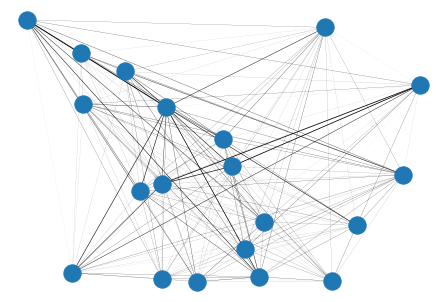

In [15]:
plot_difference(J)
np.savetxt("original_seattle.csv", J, delimiter=",")

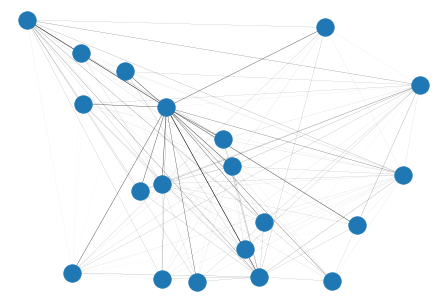

In [16]:
plot_difference(J-projected_J)
np.savetxt("difference_seattle_l2.csv", projected_J-J, delimiter=",")

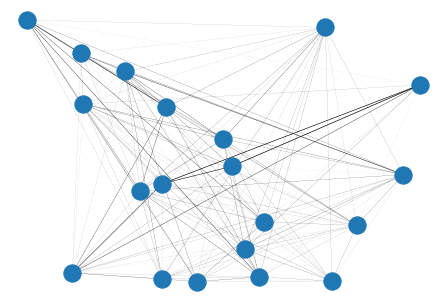

In [17]:
plot_difference(projected_J)
np.savetxt("projected_seattle_l2.csv", projected_J, delimiter=",")

In [13]:
print(J-projected_J)
np.savetxt("difference_seattle_l2.csv", J-projected_J, delimiter=",")

[[ 0.00000000e+00  3.40170605e-02  1.47073427e-01  4.41970244e-02
   5.84667715e-02  1.53076629e-01  1.23061551e-01  7.83989157e-02
   3.49413540e-02  1.16067427e-01  4.16723727e-02  2.90144870e-02
   4.10205002e-02  2.58129080e-01  1.46073066e-01  1.72543869e-08
   4.42228493e-02  1.30150241e-01  2.80139718e-02  2.75188481e-02]
 [ 3.40170605e-02  0.00000000e+00  3.21611444e-01  4.30215547e-02
   2.80140509e-02  1.34067170e-01  3.40170230e-01  6.80340785e-02
   1.10055338e-02  2.70135738e-02  7.20361102e-02  1.80090317e-02
   3.90195517e-02  4.25676023e-01  1.29064608e-01  5.60281161e-02
   7.94725497e-02  1.34067065e-01  5.40270330e-02  4.90246773e-02]
 [ 1.47073427e-01  3.21611444e-01  0.00000000e+00  1.30064907e-01
   4.00198741e-02  4.69684295e-01  5.71736455e-01  6.40318927e-02
   3.60178629e-02  1.90093881e-02  6.90344118e-02  5.60278666e-02
   6.80338822e-02  2.77138456e-01  3.90193858e-02  4.00199150e-02
   8.40418764e-02  5.80288415e-02  1.70083344e-02  5.20259875e-02]
 [ 4.41

In [9]:
print(projected_J)

[[ 0.00000000e+00 -4.91824024e-08  1.22158188e-07  3.78440030e-02
   3.56424918e-03 -7.77268382e-08 -1.00873783e-08  2.64161133e-03
   2.07715835e-03  4.00106246e-02  2.34964195e-03  2.26672601e-08
   1.35217766e-08  5.89819493e-09 -1.70201403e-08 -1.72543869e-08
   1.78081714e-02  4.49373170e-02  3.75285462e-08  3.85141740e-02]
 [-4.91824024e-08  0.00000000e+00  8.85936925e-02 -4.03064551e-08
  -4.15380662e-08 -1.25154819e-07 -1.17075990e-07 -5.58190128e-08
  -3.01219299e-08 -6.47854830e-08 -8.62313426e-08 -2.56682109e-08
  -3.87037837e-08  3.85561317e-02 -6.51438068e-08 -9.74124615e-08
   6.25984977e-02 -2.07995173e-08 -1.50226845e-08 -1.60947431e-07]
 [ 1.22158188e-07  8.85936925e-02  0.00000000e+00  1.36765968e-07
   1.39217872e-07  5.05758780e-02  5.05747525e-02  1.28624315e-07
   1.49146544e-07  1.18246133e-07  1.11246273e-07  1.52130622e-07
   1.40533254e-07  1.36266194e-07  1.27229442e-07  9.83296699e-08
   1.51599724e-07  1.77885292e-07  1.71315297e-07  2.98243902e-08]
 [ 3.78

In [12]:
# here we compute l2 projection onto the Safe Polytope
start_time = time.time()
projected_J, projected_h = l2_project(J, h, secure=3, margin=0.0001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Number of constraints:  2131
Optimal value: 2.550266874507897
Found projection in 19.352200984954834 sec.


Now, infecting node 0 does not create any other infections:

In [6]:
result = gurobi_map_explicit(projected_J, projected_h, [0])
print(result)


Statistics for model map :
  Linear constraint matrix    : 1 Constrs, 20 Vars, 1 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.398685, 0.398688 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.694667487964156
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0]


However, if two nodes are infected, then again all nodes are infected in MAP state:

In [7]:
result = gurobi_map_explicit(projected_J, projected_h, [0, 1])
print(result)


Statistics for model map :
  Linear constraint matrix    : 2 Constrs, 20 Vars, 2 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.398685, 0.398688 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  1.6936661864880764
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [8]:
# here we compute l1 projection onto the Safe Polytope(2)
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=2, margin=0.001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Optimal value: 43.62073910350217
Found projection in 3.0805139541625977 sec.


In [9]:
result = gurobi_map_explicit(projected_J, projected_h, [0, 1])
print(result)


Statistics for model map :
  Linear constraint matrix    : 2 Constrs, 20 Vars, 2 NZs
  Variable types              : 0 Continuous, 20 Integer (20 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0.195125, 0.210545 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 1, 1 ]
Energy value:  0.7309526900870025
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]


In [10]:
# here we compute l1 projection onto the Safe Polytope(3)
start_time = time.time()
projected_J, projected_h = l1_project(J, h, secure=3, margin=0.001)
end_time = time.time()
print('Found projection in {} sec.'.format(end_time-start_time))

Optimal value: 44.308961587876254
Found projection in 11.08910083770752 sec.
